# CITS5508 Lab 4: AdaBoost and Gradient Boosting Regressor on White wine quality

Name: Joey Koh<br>
Student number: 21506379  
Date created: 13 April 2020  
Last modified: 20 April 2020  

This notebook compares the performance of AdaBoosting and GradientBoosting on a regressor task. It is addressing a regression task on predicting white wine quality using various physiochemical inputs.<br>

Input variables (based on physicochemical tests):<br>
- 1 - fixed acidity
- 2 - volatile acidity
- 3 - citric acid
- 4 - residual sugar
- 5 - chlorides
- 6 - free sulfur dioxide
- 7 - total sulfur dioxide
- 8 - density
- 9 - pH
- 10 - sulphates
- 11 - alcohol<br>

Output variable (based on sensory data):
- 12 - quality (score between 0 and 10)<br>

An AdaBoost with SVR base estimator and GradientBoost with Decision Tree base estimator are used and judged in performance.

Todo:
- [ ] Search for and answer "HELP" "EDIT", REMOVE
- [ ] fix the histogram offcentre
- [ ] learning curves for MSE?
- conclusions, explanations
- You can also superimpose the two histograms (of the training and testing sets) together on the same plot.



Ask:
- do we have to tune hyperparameters with a gridsearch? not necessarily, might be too long.
- Based on the rubric, we dont need to explain MSE graph till the conclusion? unlike histogram of raw errors?

## 1. Setup, Data Cleaning and Visualisation
Import libraries to be used and bring the data in. Clean the data for use.<br>
Perform basic visualisations to have a feel of data.<br>

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
#Use jupyter's backend to render plots
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pandas.plotting import scatter_matrix
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC #EDIT remove
from sklearn.ensemble import AdaBoostClassifier #EDIT remove
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.svm import SVR #for regression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import warnings
#warnings.filterwarnings("ignore") #clear warnings

#Prepare the data, separate cols by semi-colon
raw_data = pd.read_csv("winequality-white.csv", delimiter= ";" )

#Quick check for missing values
print("Are there any missing values?", raw_data.isnull().values.any())

#View first few lines and inspect columns
raw_data.head()

Are there any missing values? False


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Looking at the first few lines, we observe that the data is all numerical. Hence, there is no need for text handling. Also no missing values to clean up.

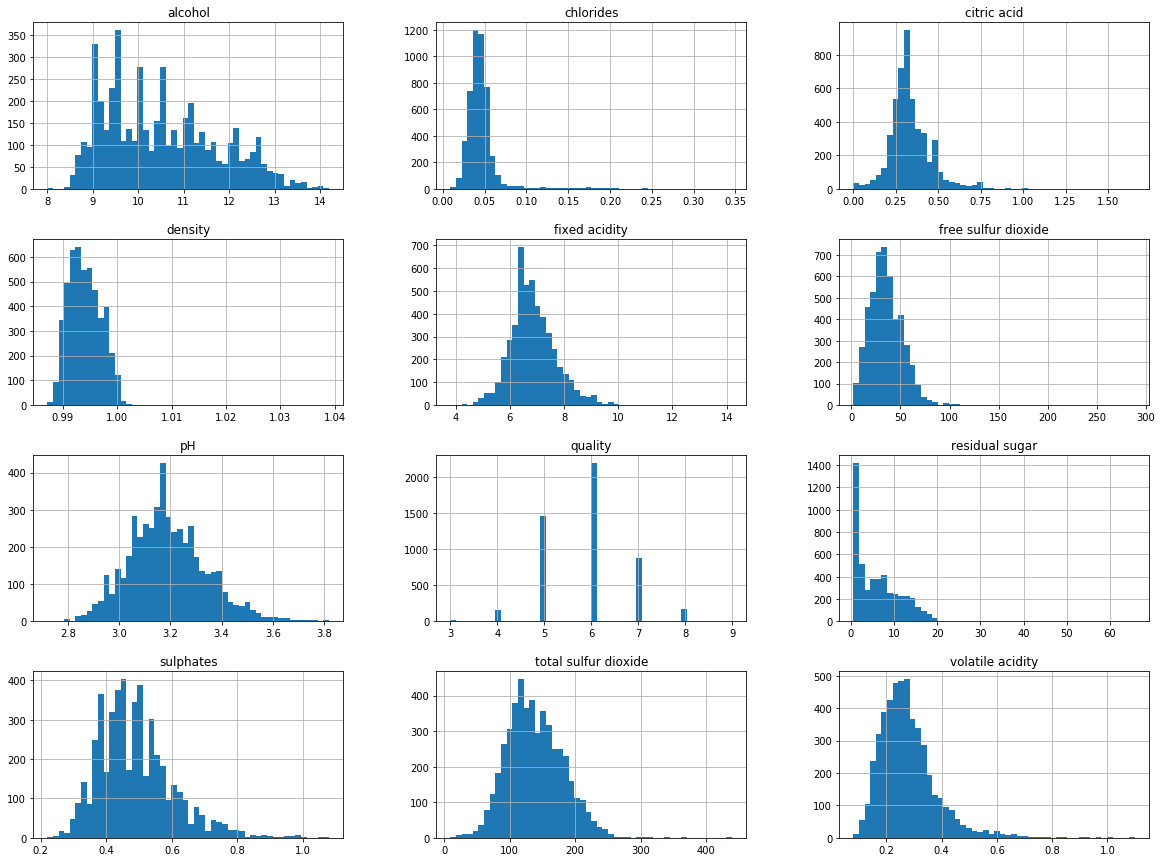

In [2]:
data = raw_data #make a copy
#Generate histograms
data.hist(bins=50, figsize=(20,15))
plt.show()

HELP compute logs for tail heavy dist?
data quirks? like lines in correlation graphs?

These are the graphs showing the distribution for each attribute.<br>
Observations:
- All attributes appear continuous in the sense that from their scale, there is no significant break in value increments. Except for 'quality', which appears to be integers in the range from 3 to 9. Thus, while this may be a regression task, we would likely need to round the predicted outputs.
- All attributes have some normal distribution adherence. 'chlorides', 'citric acid', 'density', 'free sulfur dioxide', 'residual_sugar', and 'violatile acidity' have some degree of positive skew. 

- There are odd spikes in some distributions in attributes which a StandardScaler would deal better with compared to a MinMaxScaler. For this reason, standardization was used in the pipeline to normalise the data. In this, firstly the column's mean value is subtracted from every value in the column, then divided by the standard deviation. The resulting distribution has unit variance. Thus, the outlier spikes have less of an impact compared to MinMax scaling.


EDIT try a correlation scatter plot?

## 2. Data Splitting and Normalisation
Split dataset then feature scale based on training features. 

In [3]:
#Separate features and labels
y = data["quality"]
X = data.drop("quality",axis=1)

#Split dataset at 85/15 ratio, 
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size= 0.15, random_state= 0)

#Data Normalisation
std_scaler = StandardScaler()
std_scaler.fit(train_X) #based on training features
train_X_tr = std_scaler.transform(train_X)
test_X_tr = std_scaler.transform(test_X)

**Feature scaling is required for the AdaBoost Regressor** as it uses the Support Vector Regressor as the base estimator. This Support Vector Machines are sensitive to feature scales. In a SVR, we are trying to fit as many instances as possible on the narrowest street while limiting margin violations. Thus, the relative scales of different features matter and can affect the fitting process. **Normalised data is used for AdaBoost later.**<br>

**Feature scaling is not required for the GradientBoost Regressor** as it uses decision trees as the weak learner base estimator. Tree based models are constucted in a greedy manner, by choosing the best split points to minimise the loss function. Thus, the relative scales of different features do not matter. The **unscaled data is used for GradientBoost later.** 

## 3. AdaBoost Regressor
Incremental learning by adjusting relative weights of misclassified instances.

In [4]:
#functions used for both AdaBoost and GradientBoost Sections
def displayMSE(title, label1, mse1, label2, mse2): #function for plotting and printing Mean Sq Errors
    plt.scatter(list(range(1,7)), mse1, marker='*')
    plt.plot(list(range(1,7)), mse1, label=label1)
    plt.scatter(list(range(1,7)), mse2, marker='o')
    plt.plot(list(range(1,7)),mse2, label=label2)
    plt.title(title)
    plt.legend(loc='best')
    plt.ylabel('MSE')
    plt.xlabel('Estimator no.')
    plt.show()
    print(label1,": These are the MSEs for each estimator model from first to last:")
    print(mse1)
    print(label2,": These are the MSEs for each estimator model from first to last:")
    print(mse2)
    
def getPredictionAndRawErrors(model, features_X, labels_y): #returns rounded predictions and raw prediction errors
    pred = model.predict(features_X) #get prediction values
    pred_round = pred.round() #round predictions
    pred_round = pred_round.astype("int64") #change to integer type
    raw_errors = pred_round - labels_y #compute raw prediction errors
    return pred_round, raw_errors

def displayRawErrors(raw_errors,title): #plots raw error histogram
    raw_errors.hist(align= "mid")
    #np.histogram(raw_errors, bins=50) EDIT
    #plt.bar(raw_errors)
    plt.title(title)
    plt.ylabel("Count")
    plt.xlabel("Raw Error of Quality")
    plt.show()

In [5]:
#Prepare regressor
"""
ada_reg = AdaBoostRegressor( 
    base_estimator=SVR(kernel= "rbf"), 
    n_estimators=6, 
    random_state=0)
ada_reg.fit(train_X_tr, train_y) #fit training set
""";


In [6]:

#HELP trying classfier instead, how does this still work?
ada_reg = AdaBoostClassifier( 
    SVC(kernel= "rbf"),algorithm="SAMME", 
    n_estimators=6, 
    random_state=0)
ada_reg.fit(train_X_tr, train_y) #fit training set

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                      class_weight=None, coef0=0.0,
                                      decision_function_shape='ovr', degree=3,
                                      gamma='scale', kernel='rbf', max_iter=-1,
                                      probability=False, random_state=None,
                                      shrinking=True, tol=0.001,
                                      verbose=False),
                   learning_rate=1.0, n_estimators=6, random_state=0)

### 3.1 Mean Squared Errors

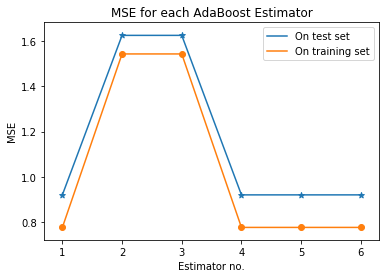

On test set : These are the MSEs for each estimator model from first to last:
[0.9211, 1.6245, 1.6245, 0.9211, 0.9211, 0.9211]
On training set : These are the MSEs for each estimator model from first to last:
[0.7776, 1.5426, 1.5426, 0.7776, 0.7776, 0.7776]


In [7]:
#Get MSE for each stage, from rounded predictions on test and training sets
test_ada_mse = [mean_squared_error(test_y, test_y_ada_pred.round()).round(4) 
             for test_y_ada_pred in ada_reg.staged_predict(test_X_tr)]
train_ada_mse = [mean_squared_error(train_y, train_y_ada_pred.round()).round(4) 
             for train_y_ada_pred in ada_reg.staged_predict(train_X_tr)]

#Call display function
displayMSE("MSE for each AdaBoost Estimator", "On test set", test_ada_mse, "On training set",train_ada_mse )


Note: The AdaBoosting regressor is fitted on the training data.<br>
As the number of estimators increases, the Mean Squared Errror on the training set decreases as the model learns to fits the data better.<br>
However, we observe the model having a consistently higher MSE on the test set as the model was not trained on it. Interestingly, the MSE begins to slightly climb from the 6th estimator on the test set. This is due to **overfitting beginning to occur.**

### 3.2 Rounded Predictions and Raw Errors

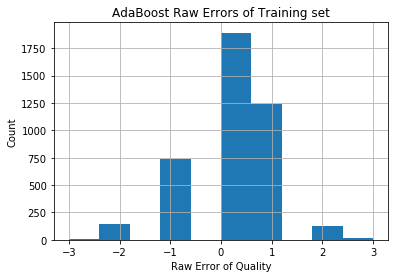

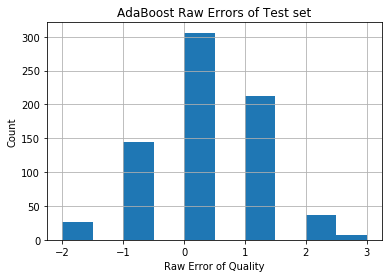

In [8]:
#On training set: Call rounded predictions and raw errors function
train_ada_pred, train_ada_raw_errors = getPredictionAndRawErrors(ada_reg, train_X_tr, train_y)
displayRawErrors(train_ada_raw_errors,"AdaBoost Raw Errors of Training set")

#On test set: Call rounded predictions and raw errors function
test_ada_pred ,test_ada_raw_errors = getPredictionAndRawErrors(ada_reg, test_X_tr, test_y)
displayRawErrors(test_ada_raw_errors,"AdaBoost Raw Errors of Test set")


From the histogram of AdaBoost raw errors on the training set, there is a roughly normal distribution. Note that the slightly higher -1 errors compared to the +1 errors. This implies that the AdaBoost regressor slightly underestimates wine quality more than overestimates it.

From the histogram of AdaBoost raw errors on the test set, there is a roughly normal distribution. Note that the slightly higher -1 errors compared to the +1 errors. This implies that the AdaBoost regressor slightly underestimates wine quality more than overestimates it.<br>

As the relative proportions of bars plotted for test set is similar to the proportions for the training set, there is no obvious overfitting.

## 4. GradientBoost Regressor
Incremental learning by trying to fit estimator on the residuals of previous redisual errors

In [9]:
#Prepare regressor
gb_reg = GradientBoostingClassifier(
    n_estimators=6,
    random_state=0,
    learning_rate= 0.5,
    warm_start=True)

gb_reg.fit(train_X, train_y) #fit training set

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=6,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=True)

### 4.1 Mean Squared Errors

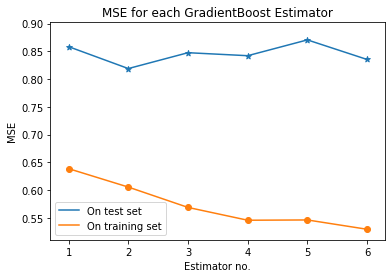

On test set : These are the MSEs for each estimator model from first to last:
[0.8585, 0.819, 0.8476, 0.8422, 0.8707, 0.8354]
On training set : These are the MSEs for each estimator model from first to last:
[0.6385, 0.6053, 0.5686, 0.5455, 0.546, 0.5292]


In [10]:
#Get MSE at each estimator's stage, with rounded predictions on training and test sets
test_gb_mse = [mean_squared_error(test_y, test_pred.round()).round(4)
         for test_pred in gb_reg.staged_predict(test_X)]
train_gb_mse = [mean_squared_error(train_y, train_pred.round()).round(4)
         for train_pred in gb_reg.staged_predict(train_X)]

displayMSE("MSE for each GradientBoost Estimator", "On test set", test_gb_mse, "On training set",train_gb_mse )


We observe the trade-off between bias and variance here.<br>
Note: The GradientBoosting regressor is fitted on the training data.<br>
As the number of estimators increases, the Mean Squared Errror on the training set decreases as the model learns to fits the data better.<br>
However, we observe the model having a consistently higher MSE on the test set as the model was not trained on it. Interestingly, the MSE begins to slightly climb from the 6th estimator on the test set. This is due to **overfitting beginning to occur.**

### 4.2 Rounded Predictions and Raw Errors

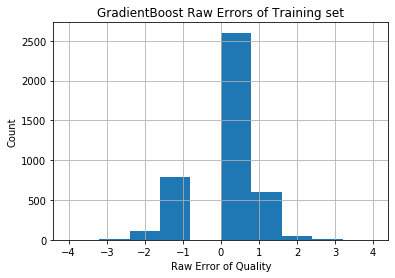

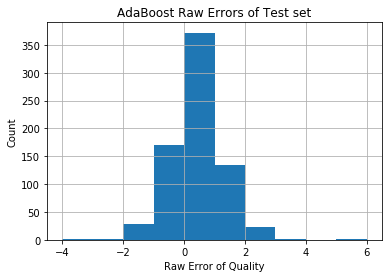

In [11]:
#On training set: Call rounded predictions and raw errors function
train_gb_pred, train_gb_raw_errors = getPredictionAndRawErrors(gb_reg, train_X, train_y)
displayRawErrors(train_gb_raw_errors,"GradientBoost Raw Errors of Training set")

#On test set: Call rounded predictions and raw errors function
test_gb_pred ,test_gb_raw_errors = getPredictionAndRawErrors(gb_reg, test_X, test_y)
displayRawErrors(test_gb_raw_errors,"AdaBoost Raw Errors of Test set")

## 5. Conclusion